### Set up water network model

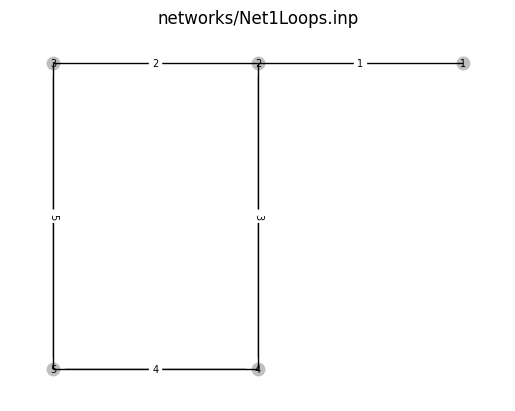

2    3170.0
3    3170.0
4    3804.0
5    8560.0
dtype: float64

In [2]:
import os
from pathlib import Path
import wntr
import wntr_quantum

# Define the directory path
epanet_tmp_dir = Path("/Users/murilo/scratch_dir/pipe_break")

# check if the directory exists
if not epanet_tmp_dir.exists():
    epanet_tmp_dir.mkdir(parents=True, exist_ok=True)

# set the environment variables
os.environ["EPANET_TMP"] = str(epanet_tmp_dir)
os.environ["EPANET_QUANTUM"] = "/Users/murilo/Documents/NLeSC_Projects/Vitens/EPANET"

# set up network model
inp_file = 'networks/Net1Loops.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# plot network
wntr.graphics.plot_network(
    wn,
    title=wn.name,
    node_size=100,
    node_labels=True,
    link_labels=True,
    node_alpha=0.25,
)

# calculate population per junction
population = wntr.metrics.population(wn)

population

### Set simulation options

In [16]:
# explicitly set Hazen-Williams headloss formulas and pressure dependent demand mode
wn.options.hydraulic.headloss = 'H-W'
wn.options.hydraulic.demand_model = 'PDD'

for ix, ip in enumerate(wn.pipe_name_list):
    pipe = wn.get_link(ip)
    print(f"Pipe {ip} diameter (m): {pipe.diameter}")

minimum_pressure = 5 # m
required_pressure = 30 # m
min_pipe_diam = 0.0 # m => includes all pipes in the analysis

start_time = 2*3600 # 2 hours
break_duration = 2*3600 # 2 hours
total_duration = start_time + break_duration # 4 hours

# Set hydraulic parameters
wn.options.hydraulic.demand_model = 'PDD'    
wn.options.time.duration = total_duration
wn.options.hydraulic.minimum_pressure = minimum_pressure
wn.options.hydraulic.required_pressure = required_pressure

# calculate average expected demand
AED = wntr.metrics.average_expected_demand(wn) # m3/s

# identify junctions with non-zero average expected demand (AED)
# e.g, exclude reservoirs, tanks, etc.
nzd_junct = AED[AED > 0].index

AED, nzd_junct

Pipe 1 diameter (m): 0.4572
Pipe 2 diameter (m): 0.203
Pipe 3 diameter (m): 0.457
Pipe 4 diameter (m): 0.153
Pipe 5 diameter (m): 0.153


(2    0.02777
 3    0.02777
 4    0.03333
 5    0.07500
 dtype: float64,
 Index(['2', '3', '4', '5'], dtype='object'))

### Solve model under normal conditions

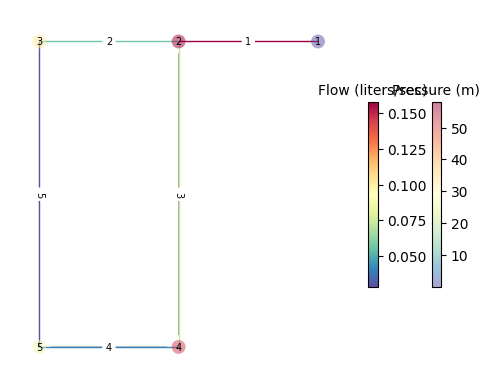

(               2          3          4          5
 7200   58.534618  44.519516  52.977352  15.014784
 10800  58.534618  44.519516  52.977352  15.014784
 14400  58.534618  44.519516  52.977352  15.014784
 18000  58.534618  44.519516  52.977352  15.014784
 21600  58.534618  44.519516  52.977352  15.014784,
 Index([], dtype='object'))

In [17]:
# define classical solver using EpanetSimulator 
sim = wntr.sim.EpanetSimulator(wn)

# run the classical EPANET simulation
results_original_epanet = sim.run_sim()

# plot network
wntr.graphics.plot_network(
    wn,
    node_attribute=results_original_epanet.node["pressure"].iloc[0],
    link_attribute=results_original_epanet.link["flowrate"].iloc[0],
    node_colorbar_label='Pressure (m)',
    link_colorbar_label='Flow (liters/sec)',
    node_size=100,
    node_labels=True,
    link_labels=True,
    node_alpha=0.5,
)

# results_original_epanet.node["pressure"], results_original_epanet.link["velocity"]

# Save junction pressure results and identify junctions that fall below minimum pressure
pressure = results_original_epanet.node['pressure'].loc[start_time::, nzd_junct]
normal_pressure_below_pmin = pressure.columns[(pressure < minimum_pressure).any()]

pressure, normal_pressure_below_pmin

In [18]:
### Query pipes to include in analysis

In [19]:
import numpy as np

# query all pipes with diameter greater than threshold set in 1c
pipes_of_interest = wn.query_link_attribute('diameter', np.greater_equal, min_pipe_diam)

pipes_of_interest

1    0.4572
2    0.2030
3    0.4570
4    0.1530
5    0.1530
dtype: float64

### Simulate hydraulics with broken pipes

In [22]:
# create dictionary to save results
analysis_results = {}

# simulate pipe break (simulated as pipe closures) for each pipe
for pipe_name in pipes_of_interest.index:
    
    print(f"Pipe to be broken: {pipe_name}")

    wn = wntr.network.WaterNetworkModel(inp_file)
    wn.options.hydraulic.demand_model = 'PDD'    
    wn.options.time.duration = total_duration
    wn.options.hydraulic.minimum_pressure = minimum_pressure
    wn.options.hydraulic.required_pressure = required_pressure
    
    # create pipe closure control and apply to pipe of interest
    pipe = wn.get_link(pipe_name)
    act = wntr.network.controls.ControlAction(pipe, 'status', 0)
    cond = wntr.network.controls.SimTimeCondition(wn, 'Above', start_time)
    ctrl = wntr.network.controls.Control(cond, act)
    wn.add_control('close pipe ' + pipe_name, ctrl)
    
    try:
        # simulate hydraulics
        sim = wntr.sim.WNTRSimulator(wn)
        sim_results = sim.run_sim()
 
        # using pressure results, identify impacted junctions
        sim_pressure = sim_results.node['pressure'].loc[start_time::, nzd_junct]
        sim_pressure_below_pmin = sim_pressure.columns[(sim_pressure < minimum_pressure).any()]
        impacted_junctions = set(sim_pressure_below_pmin) - set(normal_pressure_below_pmin)
        impacted_junctions = list(impacted_junctions)
        
    except Exception as e:
        # Identify failed simulations and the reason
        impacted_junctions = None
        print(pipe_name, ' Failed:', e)

    finally:
        # Save simulation results
        analysis_results[pipe_name] = impacted_junctions
        
    print(analysis_results[pipe_name])

Pipe to be broken: 1
['5', '4', '2', '3']
Pipe to be broken: 2
[]
Pipe to be broken: 3
[]
Pipe to be broken: 4
[]
Pipe to be broken: 5
[]


### Visualize results

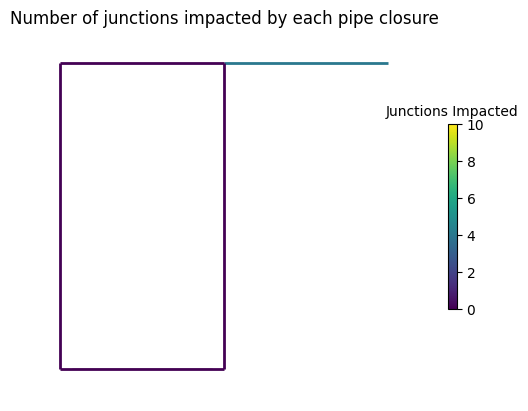

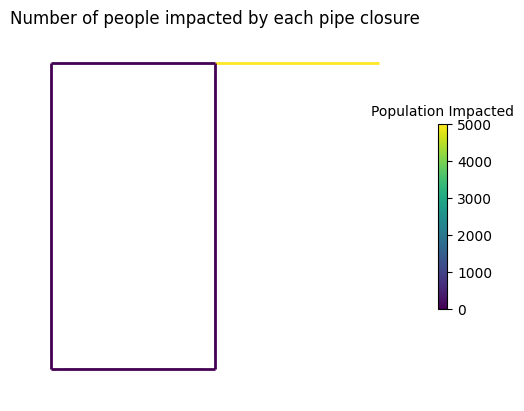

<Axes: title={'center': 'Number of people impacted by each pipe closure'}>

In [12]:
import matplotlib
import matplotlib.pyplot as plt

# save junction and population impact results to dictionary
num_junctions_impacted = {}
num_people_impacted = {}
for pipe_name, impacted_junctions in analysis_results.items():
    if impacted_junctions is not None:
        num_junctions_impacted[pipe_name] = len(impacted_junctions)
        num_people_impacted[pipe_name] = population[impacted_junctions].sum()
        
        
# Set colormap for network maps
cmap=matplotlib.colormaps['viridis']
        
# plot junctions impacted due to pipe breaks
wntr.graphics.plot_network(wn, link_attribute=num_junctions_impacted, node_size=0, link_width=2, 
                           link_range=[0,10], link_cmap = cmap, link_colorbar_label='Junctions Impacted', 
                           title='Number of junctions impacted by each pipe closure')

#Plot population impacted due to pipe breaks
wntr.graphics.plot_network(wn, link_attribute=num_people_impacted, node_size=0, link_width=2, 
                           link_range=[0,5000], link_cmap = cmap, link_colorbar_label='Population Impacted',
                           title='Number of people impacted by each pipe closure')

### Solve model using the classical Cholesky solver from `QuantumEpanetSimulator`

We now solve the same problem using the classical Epanet simulator. Note that, by default, `QuantumEpanetSimulator` uses a classical `CholeskySolver` by default to iteratively solve the linear problem.

In [3]:


# save number of nodes and pipes
n_nodes = len(results_epanet.node["pressure"].iloc[0]), 
n_pipes = len(results_epanet.link["flowrate"].iloc[0])

results_epanet.node["pressure"], results_epanet.link["velocity"]

Your EPANET quantum path: /Users/murilo/Documents/NLeSC_Projects/Vitens/EPANET
Your EPANET temp dir: /Users/murilo/scratch_dir/.epanet_quantum

Size of the Jacobian in EPANET simulator: 6
Size of the b vector in EPANET simulator: 6


(name          2          3          4          5         6          7  \
 0     53.247612  30.466719  43.450195  33.808483  30.44593  30.553486   
 
 name             1  
 0     4.394531e-07  ,
 name         1         2         3         4         5         6         7  \
 0     1.894883  1.846514  1.462829  1.115635  1.136152  1.099438  1.298483   
 
 name         8  
 0     0.315222  )

### Check that the classical results are equivalent

In [4]:
import pandas.testing as pdt

pdt.assert_frame_equal(results_original_epanet.node["pressure"], results_epanet.node["pressure"])
pdt.assert_frame_equal(results_original_epanet.link["flowrate"], results_epanet.link["flowrate"])
# pdt.assert_frame_equal(results_original_epanet.link["velocity"], results_epanet.link["velocity"])

### Define a helper function

Before proceeding to the proper quantum solution of the water network model, let's define a helper function. This function checks that the quantum results are within `TOL`% of those obtained classically. It also fills in lists containing the final values of pressures and flow rates obtained.

In [5]:
TOL = 5  # => per cent
DELTA = 1.0e-12


def get_ape_from_pd_series(quantum_pd_series, classical_pd_series):
    """Helper function to evaluate absolute percentage error between classical and quantum results."""
    ape = abs(quantum_pd_series - classical_pd_series) * 100.0 / abs(classical_pd_series + DELTA)
    return ape


def compare_results(classical_result, quantum_result):
    """
    Helper function that compares the classical and quantum simulation results.
    """
    classical_data = []
    quantum_data = []

    def check_ape(classical_value, quantum_value):
        """Helper function to check if the absolute percentage error between classical and quantum results is within TOL."""
        ape = abs(quantum_value - classical_value) * 100.0 / abs(classical_value + DELTA)
        is_close_to_classical = ape <= TOL
        if is_close_to_classical:
            print(f"Quantum result {quantum_value} within {ape}% of classical result {classical_value}")
            quantum_data.append(quantum_value)
            classical_data.append(classical_value)
        return is_close_to_classical

    for link in classical_result.link["flowrate"].columns:
        classical_value = classical_result.link["flowrate"][link].iloc[0]
        quantum_value = quantum_result.link["flowrate"][link].iloc[0]
        message = f"Flowrate {link}: {quantum_value} not within {TOL}% of classical result {classical_value}"
        assert check_ape(classical_value, quantum_value), message

    for node in classical_result.node["pressure"].columns:
        classical_value = classical_result.node["pressure"][node].iloc[0]
        quantum_value = quantum_result.node["pressure"][node].iloc[0]
        message = f"Pressure {node}: {quantum_value} not within {TOL}% of classical result {classical_value}"
        assert check_ape(classical_value, quantum_value), message

    return classical_data, quantum_data

### Solve water network with `QuantumEpanetSimulator` and VQLS 

We now solve the model using VQLS. In this example, we are **preconditioning** the initial linear system using *diagonal scaling* and also using a **mix of two classical optimizers**.

In [6]:
import numpy as np

from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_algorithms import optimizers as opt

from quantum_newton_raphson.vqls_solver import VQLS_SOLVER

n_qubits = int(np.ceil(np.log2(epanet_A_dim)))

qc = RealAmplitudes(n_qubits, reps=3, entanglement="full")
estimator = Estimator()

linear_solver = VQLS_SOLVER(
    estimator=estimator,
    ansatz=qc,
    optimizer=[opt.COBYLA(maxiter=1000, disp=True), opt.CG(maxiter=500, disp=True)],
    matrix_decomposition="symmetric",
    verbose=True,
    preconditioner="diagonal_scaling",
    reorder=True,
)

sim = wntr_quantum.sim.QuantumEpanetSimulator(wn, linear_solver=linear_solver)
results_vqls = sim.run_sim(linear_solver=linear_solver)

results_classical, results_quantum = compare_results(results_epanet, results_vqls)

results_vqls.node["pressure"], results_vqls.link["velocity"]

VQLS Iteration 1000 Cost 6.643e-03
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS = 1000   F = 6.643069E-03    MAXCV = 0.000000E+00
   X =-6.003301E-01  -1.100831E+00  -1.251520E+00  -1.103777E+00   1.332641E-01
       2.956498E+00   8.709108E-01   1.550173E+00   7.461350E-01   2.731111E-01
      -2.069924E+00   1.162553E+00
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 74
         Function evaluations: 1599
         Gradient evaluations: 123
VQLS Iteration 1000 Cost 1.396e-02
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS = 1000   F = 1.395057E-02    MAXCV = 0.000000E+00
   X = 4.137658E-01  -1.559580E+00   7.397351E-01   1.718300E+00   2.247472E+00
      -2.605908E+00  -5.912157E-01  -1.401045E+00   2.133813E+00   4.532001E+00
       1.376001E+00   2.235611E-01
Optimization terminated successfully.
         Current function value: 0.000000
         It

(name          2          3          4          5          6          7  \
 0     53.246571  30.469509  43.447197  33.812408  30.442118  30.548964   
 
 name             1  
 0     4.394531e-07  ,
 name         1         2        3         4         5         6         7  \
 0     1.895041  1.846214  1.46315  1.115356  1.136319  1.099524  1.298364   
 
 name         8  
 0     0.315162  )

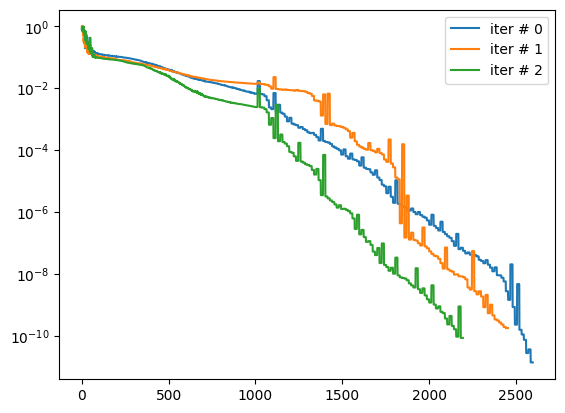

In [7]:
import matplotlib.pyplot as plt
for i, result in enumerate(results_vqls.linear_solver_results):
    plt.semilogy(result.logger.values, label=f"iter # {i}")
    plt.legend()

### Plot Network model with absolute percent errors

To compare the results, we plot the network together with the absolute percent errors (with respect to the classical results) for the predicted pressures and flow rates.

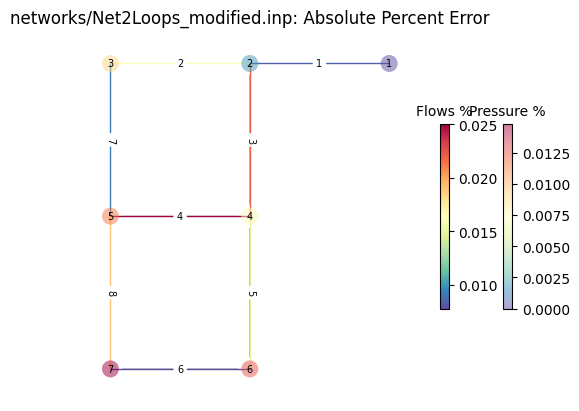

<Axes: title={'center': 'networks/Net2Loops_modified.inp: Absolute Percent Error'}>

In [8]:

wntr.graphics.plot_network(
    wn,
    node_attribute=get_ape_from_pd_series(
        results_vqls.node["pressure"].iloc[0],
        results_epanet.node["pressure"].iloc[0]
    ),
    link_attribute=get_ape_from_pd_series(
        results_vqls.link["flowrate"].iloc[0],
        results_epanet.link["flowrate"].iloc[0],
    ),
    node_colorbar_label='Pressure %',
    link_colorbar_label='Flows %',
    node_size=150,
    title=f"{inp_file}: Absolute Percent Error",
    node_labels=True,
    link_labels=True,
    node_alpha=0.5,
)

### Plot pressures and flow rates

Let's check graphically the equivalence of the results.

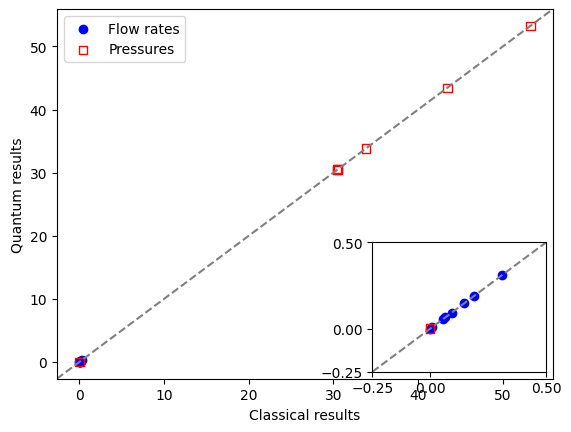

([0.31109074,
  0.09356474,
  0.18975493,
  0.009044859,
  0.14737916,
  0.055709664,
  0.06579549,
  -0.00015972625,
  53.247612,
  30.466719,
  43.450195,
  33.808483,
  30.44593,
  30.553486,
  4.3945312e-07],
 [0.31111667,
  0.093549564,
  0.18979658,
  0.009042595,
  0.14740083,
  0.055714004,
  0.065789424,
  -0.00015969579,
  53.24657,
  30.46951,
  43.447197,
  33.81241,
  30.442118,
  30.548964,
  4.3945312e-07])

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots()
ax.scatter(results_classical[:n_pipes], results_quantum[:n_pipes], label="Flow rates", color="blue", marker="o")
ax.scatter(results_classical[n_pipes:], results_quantum[n_pipes:], label="Pressures", color="red", marker="s", facecolors='none')
ax.axline((0, 0), slope=1, linestyle="--", color="gray", label="")
ax.set_xlabel("Classical results")
ax.set_ylabel("Quantum results")
ax.legend()

# inset plot
ax_inset = inset_axes(ax, width="35%", height="35%", loc="lower right")
ax_inset.scatter(results_classical[:n_pipes], results_quantum[:n_pipes], color="blue", marker="o")
ax_inset.scatter(results_classical[n_pipes:], results_quantum[n_pipes:], color="red", marker="s", facecolors='none')
ax_inset.axline((0, 0), slope=1, linestyle="--", color="gray")
ax_inset.set_xlim(-0.25, 0.5)
ax_inset.set_ylim(-0.25, 0.5)
ax_inset.set_xticks([-0.25, 0, 0.5])
ax_inset.set_yticks([-0.25, 0, 0.5])
# plt.legend()
plt.show()

results_classical, results_quantum